In [151]:
from afqinsight.datasets import AFQDataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import sklearn
from importlib import reload
import tools 
reload (tools)
from tools import crossvalidation

In [26]:
from sklearn.utils import shuffle

In [3]:
AFQDataset.from_files

<function afqinsight.datasets.AFQDataset.from_files(fn_nodes='nodes.csv', fn_subjects='subjects.csv', dwi_metrics=None, target_cols=None, label_encode_cols=None, index_col='subjectID', unsupervised=False, concat_subject_session=False, enforce_sub_prefix=True)>

In [4]:
sklearn.__version__

'0.23.2'

In [5]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="combined_tract_profiles.csv", fn_subjects="participant_data.tsv", 
    dwi_metrics=["dki_fa"],
    target_cols = ['age'],
    index_col="Observations")


In [6]:
feat_array = np.array(afq_dataset.feature_names)

In [7]:
np.unique(feat_array[:, 1])

array(['ARC_L', 'ARC_R', 'ATR_L', 'ATR_R', 'CGC_L', 'CGC_R', 'CST_L',
       'CST_R', 'FA', 'FP', 'IFO_L', 'IFO_R', 'ILF_L', 'ILF_R', 'SLF_L',
       'SLF_R', 'UNC_L', 'UNC_R'], dtype='<U6')

In [99]:
bundle_name = feat_array[::100, 1]
bundle_num = bundle_name.size

In [9]:
data = afq_dataset.X

In [10]:
data.shape

(641, 1800)

In [11]:
age = afq_dataset.y
age.shape


(641,)

In [31]:
np.std(age)

18.530637373937655

In [12]:
nan_ages = np.isnan(age)
age = age[~nan_ages]

In [13]:
age.shape

(640,)

In [14]:
data = data[~nan_ages]
data.shape

(640, 1800)

Text(0, 0.5, 'Frequency')

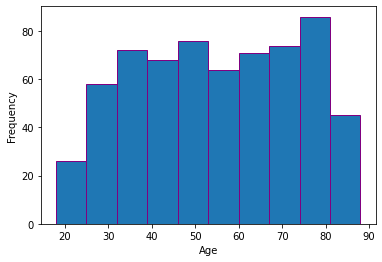

In [121]:

plt.hist(age, edgecolor='purple')
# plt.title("Distribution of Sample Age (n=640)")
plt.xlabel("Age")
plt.ylabel("Frequency")

#### create a dictionary to store bundle as key and responding data as value

In [15]:
Dict = {}
for i in range(bundle_num) :
    Dict[bundle_name[i]] = data[:, (i*100):((i+1)*100)]

In [51]:
from sklearn.impute import SimpleImputer
def impute(data):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    data_imp = imputer.fit_transform(data)
    return data_imp

function to calculate r and random r

In [136]:
def r_calculator(num_dimen, method):
    pearson_r_p = np.zeros([num_dimen, 18])
    rand_pearson_r_p = np.zeros([num_dimen, 18, 1000])
    variance = np.zeros([num_dimen, 18])
    br_p = tools.BundleReducer(method, num_dimen)
    
    for i in range(bundle_num) :
    #     data_impute = br3.impute(Dict.get(bundle_name[i]).T)
        data_imp = impute(Dict.get(bundle_name[i]))
        clf = br_p.fit(data_imp.T)
        components = clf.components_
        variance[:, i] = clf.explained_variance_ratio_

        for j in range(num_dimen):
    #         plt.scatter(age, components[0, :])
    #         plt.title('correlation between age and reduced {} in the {} component in PCA'.format(bundle_name[i], j))
    #         plt.savefig('/Users/tiffany/Desktop/UW/Rokem/image_output/correlation between age and {} in the {} component in PCA.png'.format(bundle_name[i], j), bbox_inches='tight')
            r, p = pearsonr(age, components[j, :])
            pearson_r_p[j, i] = r**2
            for k in range(1000):

                shuffled_age = shuffle(age)
                r_rand, p_rand = pearsonr(shuffled_age, components[j, :])
                rand_pearson_r_p[j, i, k] = r_rand**2
    return variance, pearson_r_p, rand_pearson_r_p

In [83]:
def p_value_calculator( true_r, rand_r):
    p_value = np.zeros([num_dimen, 18])
    for i in range(18):
        for j in range(num_dimen):
            p_value[j, i] = np.sum(rand_r[j, i, :]>true_r[j, i])/1000
    return p_value

In [107]:
def r_plotter(bundle_name, true_r, num_dimen):
    for i in range(num_dimen):
        plt.plot(bundle_name, true_r[i, :],  label='%s reduced dimension' % (i+1))

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='large'  
    )
    plt.title("pearson r of reduced dimension vairance and age for each reduced dimension")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

### look at FA data

In [152]:
fa = data[:, 900:1000]

In [153]:
br_fa = tools.BundleReducer("PCA", 4)

In [154]:
fa_imp = impute(fa)
clf =   br_fa.fit(fa_imp.T)
components = clf.components_

In [161]:
fa_imp.shape

(640, 100)

In [159]:
projection = components@fa_imp

In [160]:
projection.shape

(4, 100)

In [155]:
components.shape

(4, 640)

In [156]:
fa_recon = br_fa.reconstruct()

In [157]:
fa_recon.shape

(100, 640)

### PCA 4

In [137]:
num_dimen = 4
variance, pearson_r_p, rand_pearson_r_p = r_calculator(num_dimen, "PCA")

In [142]:
threshold = 0.05/72

In [138]:
p_value_p = p_value_calculator(pearson_r_p, rand_pearson_r_p)
p_value_p

array([[0.   , 0.005, 0.   , 0.   , 0.56 , 0.013, 0.   , 0.   , 0.   ,
        0.015, 0.029, 0.033, 0.   , 0.   , 0.004, 0.   , 0.402, 0.   ],
       [0.001, 0.992, 0.475, 0.017, 0.086, 0.06 , 0.287, 0.196, 0.019,
        0.543, 0.   , 0.004, 0.   , 0.001, 0.   , 0.   , 0.004, 0.117],
       [0.   , 0.   , 0.052, 0.535, 0.   , 0.   , 0.   , 0.005, 0.   ,
        0.   , 0.006, 0.008, 0.122, 0.545, 0.006, 0.   , 0.808, 0.044],
       [0.   , 0.   , 0.   , 0.   , 0.001, 0.029, 0.   , 0.   , 0.   ,
        0.   , 0.631, 0.394, 0.117, 0.175, 0.111, 0.13 , 0.   , 0.708]])

In [144]:
p_value_p<threshold

array([[ True, False,  True,  True, False, False,  True,  True,  True,
        False, False, False,  True,  True, False,  True, False,  True],
       [False, False, False, False, False, False, False, False, False,
        False,  True, False,  True, False,  True,  True, False, False],
       [ True,  True, False, False,  True,  True,  True, False,  True,
         True, False, False, False, False, False,  True, False, False],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True, False, False, False, False, False, False,  True, False]])

In [139]:
variance

array([[0.73804601, 0.76421547, 0.87109298, 0.84874323, 0.72755013,
        0.67563157, 0.84344684, 0.84353061, 0.94133231, 0.86767076,
        0.65009505, 0.59106565, 0.82935311, 0.85396925, 0.76684391,
        0.80830785, 0.83701292, 0.85033747],
       [0.10123924, 0.0703146 , 0.04776187, 0.06130092, 0.11405101,
        0.13725744, 0.05110514, 0.04921218, 0.01472048, 0.01993705,
        0.06131287, 0.06795125, 0.04367957, 0.02999389, 0.08056223,
        0.0745292 , 0.07623248, 0.07027476],
       [0.05770151, 0.04007991, 0.02394846, 0.02744556, 0.03280103,
        0.0352491 , 0.03160905, 0.03113239, 0.00896477, 0.01697946,
        0.03079343, 0.03570471, 0.02103618, 0.02225183, 0.04823827,
        0.03859944, 0.03238472, 0.02542133],
       [0.02392072, 0.03332595, 0.01548853, 0.01895684, 0.02217662,
        0.02673927, 0.02235372, 0.02152556, 0.0059033 , 0.01260609,
        0.02829522, 0.02944844, 0.01903303, 0.01572072, 0.02842006,
        0.02211408, 0.02311252, 0.02007375]])

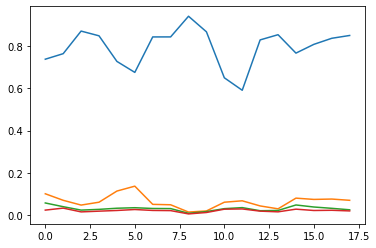

In [140]:
plt.plot(variance.T)

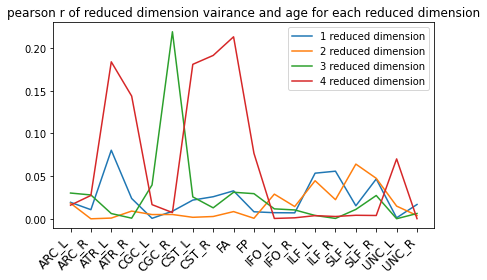

In [141]:
r_plotter(bundle_name, pearson_r_p, num_dimen)

In [124]:
0.05/72 # conservative

0.0006944444444444445

In [81]:
pd = pd.DataFrame(p_value_p, columns = bundle_name)

In [82]:
pd

,ARC_L,ARC_R,ATR_L,ATR_R,CGC_L,CGC_R,CST_L,CST_R,FA,FP,IFO_L,IFO_R,ILF_L,ILF_R,SLF_L,SLF_R,UNC_L,UNC_R
0,0.0,0.002,1.000,1.000,0.726,0.991,1.000,1.000,1.000,0.988,0.016,0.016,0.000,0.000,0.000,0.000,0.798,0.001
1,1.0,0.529,0.239,0.008,0.028,0.033,0.864,0.899,0.008,0.742,0.000,1.000,0.000,1.000,0.000,0.000,0.998,0.078
2,1.0,0.000,0.969,0.761,0.000,0.000,1.000,1.000,1.000,1.000,0.004,0.997,0.949,0.306,0.996,0.000,0.384,0.026
3,0.0,0.001,0.000,0.000,0.999,0.019,0.000,0.000,0.000,1.000,0.281,0.813,0.049,0.103,0.955,0.926,0.000,0.650


pca 3

In [112]:
num_dimen = 3
pearson_r_p, rand_pearson_r_p = r_calculator(num_dimen, "PCA")

In [113]:
p_value_p = p_value_calculator(pearson_r_p, rand_pearson_r_p)
p_value_p

array([[0.   , 0.005, 1.   , 1.   , 0.703, 0.991, 1.   , 1.   , 1.   ,
        0.989, 0.011, 0.013, 0.   , 0.   , 0.   , 0.   , 0.797, 0.001],
       [1.   , 0.504, 0.236, 0.012, 0.033, 0.03 , 0.846, 0.912, 0.009,
        0.738, 0.   , 0.999, 0.   , 1.   , 0.   , 0.   , 0.999, 0.059],
       [1.   , 0.   , 0.983, 0.768, 0.   , 0.   , 1.   , 0.997, 1.   ,
        1.   , 0.001, 0.995, 0.947, 0.307, 0.998, 0.   , 0.414, 0.019]])

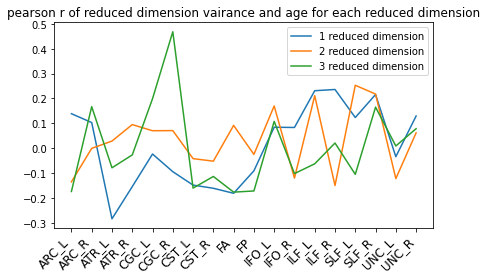

In [114]:
r_plotter(bundle_name, pearson_r_p, num_dimen)

In [115]:
df = pd.DataFrame(p_value_p, columns = bundle_name)

AttributeError: 'DataFrame' object has no attribute 'DataFrame'

nmf, 3

In [116]:
num_dimen = 3
pearson_r_n, rand_pearson_r_n = r_calculator(num_dimen, "NMF")
p_value_n = p_value_calculator(pearson_r_n, rand_pearson_r_n)
p_value_n

/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/tiffany/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.war

array([[0.965, 1.   , 0.   , 1.   , 0.146, 0.   , 0.   , 1.   , 0.857,
        0.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.972, 0.299, 0.997],
       [1.   , 0.142, 1.   , 1.   , 1.   , 1.   , 0.989, 0.746, 1.   ,
        1.   , 0.915, 0.997, 0.001, 0.414, 0.771, 1.   , 1.   , 0.995],
       [0.122, 0.021, 0.438, 0.   , 0.631, 0.73 , 1.   , 0.006, 0.   ,
        1.   , 0.057, 0.376, 1.   , 0.861, 0.06 , 0.66 , 0.007, 0.622]])

In [123]:
df = pd.DataFrame(p_value_n, columns = bundle_name)

AttributeError: 'DataFrame' object has no attribute 'DataFrame'

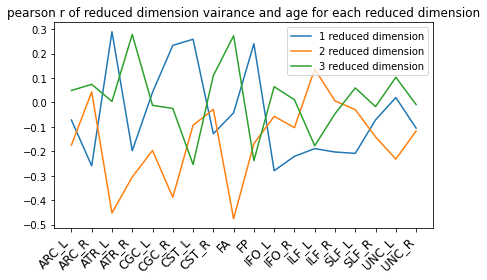

In [122]:
r_plotter(bundle_name, pearson_r_n, num_dimen)

In [44]:
p_value


array([[0.518, 0.514, 0.481, 0.542, 0.508, 0.494, 0.496, 0.499, 0.484,
        0.483, 0.496, 0.515, 0.486, 0.517, 0.498, 0.503, 0.485, 0.474],
       [0.488, 0.511, 0.503, 0.511, 0.514, 0.476, 0.483, 0.489, 0.507,
        0.508, 0.51 , 0.493, 0.501, 0.487, 0.507, 0.497, 0.513, 0.494],
       [0.481, 0.518, 0.484, 0.505, 0.475, 0.484, 0.511, 0.495, 0.486,
        0.507, 0.5  , 0.489, 0.496, 0.525, 0.488, 0.529, 0.511, 0.51 ]])

In [ ]:
pearson_r_n

In [ ]:
df = pd.

In [ ]:
sq_pearson_n = pearson_r_n**2

In [ ]:
plt.hist(sq_pearson_n[1, :])